<a href="https://colab.research.google.com/github/augustmuso/portfolios/blob/main/cryptoinvesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyportfolioopt
!pip install bta-lib
!pip install -U plotly
!pip install python-binance==0.7.9
!pip install chart_studio


     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 1.3MB 8.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.13-cp37-cp37m-linux_x86_64.whl size=2736200 sha256=4a571b284b6964356404d2e610895698f86b4bfe9535800b425fa8f1c7d05ad0
  Stored in directory: /root/.cache/pip/wheels/f9/78/00/f29636789ee83434953b5442f16ec3f9834a68e7fd0393c220
Successfully built cvxpy
  Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31
     |████████████████████████████████| 102kB 4.0MB/s 
     |████████████████████████████████| 13.2MB 320kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 501kB 9.1MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |███████

In [ ]:
# import talib as ta
import pandas as pd
import numpy as np
import btalib as ba
import time as T
from binance.client import Client
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.express as px
from binance.enums import *
from binance.exceptions import BinanceAPIException, BinanceOrderException
from decimal import Decimal

# settings
pd.options.plotting.backend = "plotly"

In [ ]:
# api key and the api secret

api_key='your api key'
api_secret='your secret key'

# puting key and secret into client

client = Client(api_key, api_secret)

In [ ]:
# create a class containing my coins and a dictionary containg the instances:
class coin(object):
    def __init__(self, ticker, time_interval):
        self.ticker = ticker
        self.time_interval = time_interval
        self.direction = None

    def madebefore(self, from_date):
        # return if from_date is greater(more current) than coinbirth
        coinbirth = client._get_earliest_valid_timestamp(self.ticker, self.time_interval)
        coinbirth = datetime.fromtimestamp(coinbirth/1000)
        return from_date > coinbirth, 'you want data from ' + str(from_date.date()) +' and coin made in ' + str(coinbirth.date())


    def coindata(self, from_date, CciPeriod):
        df = pd.DataFrame()

        bars = np.array(client.get_historical_klines(self.ticker, interval = self.time_interval,  start_str = str(from_date)))
        bars = np.delete(bars,np.s_[5:],1)

        if (self.madebefore(from_date)[0]) & (np.size(bars) > 100):
            

            columns=['date', 'open', 'high', 'low', 'close']

            df = pd.DataFrame(bars, columns = columns)
            df.set_index('date', inplace=True)
            df = df.apply(pd.to_numeric)
            df.index = pd.to_datetime(df.index, unit='ms')
            
            df['cci'] = ba.cci(df.high, df.low, df.close, period= CciPeriod).df 
        

        return df
        
    def currentprice(self):
        # gets current price and converts it to float
        return float(client.get_symbol_ticker(symbol=self.ticker)['price'])
    
    def backtest(self, df, space):
        # gets when cci crossed above or below  0.0 and then buys or sells respectively for 5 periods 
        trades = {'buy':[], 'sell':[]}
        buyreturns = []
        sellreturns = []

        # entries using df but take profit spaces back, also i trade when signal show up
        for n in np.arange(len(df.index)-space):
            if df['cci'][n-1] > 0 and df['cci'][n-2] < 0 and df['cci'][n] > df['cci'][n-1]:
                trades['buy'].append(df.index[n])
                entry = df.loc[df.index[n]]['open']
                
                #exits and profit count and stoploss
                exist = df.loc[df.index[n+space]]['close']
                pnl = (exist - entry) / entry
                buyreturns.append(pnl)
                
            if df['cci'][n-1] < 0 and df['cci'][n-2] > 0 and df['cci'][n] < df['cci'][n-1]:
                trades['sell'].append(df.index[n])
                entry = df.loc[df.index[n]]['open']
                
                #exits and profit count and stoploss
                exist = df.loc[df.index[n+space]]['close']
                pnl = (entry - exist) / entry
                sellreturns.append(pnl)
        
        return trades, buyreturns, sellreturns
    
    def plotcandles(self, df):
        # plots candles of the given data
        fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])
        
        fig.update_layout(xaxis_rangeslider_visible=False)

        fig.show()
        
    def signals(self, df):

        if df['cci'][-2] > 0 and df['cci'][-3] < 0 and df['cci'][-1] > df['cci'][-2]:
                self.direction = 1
        
        elif df['cci'][-2] < 0 and df['cci'][-3] > 0 and df['cci'][-1] < df['cci'][-2]:
                self.direction = -1

        else: self.direction = 0

        return self.direction
        

In [ ]:
symbols = ['BNBUSDT', 'BCCUSDT', 'NEOUSDT', 'LTCUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'TUSDUSDT', 'IOTAUSDT',
           'XLMUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT', 'VENUSDT', 'NULSUSDT', 'VETUSDT','BCHABCUSDT', 'BCHSVUSDT', 
           'USDCUSDT', 'LINKUSDT', 'WAVESUSDT', 'BTTUSDT', 'ONGUSDT', 'HOTUSDT', 'ZILUSDT', 'ZRXUSDT', 'FETUSDT', 'BATUSDT', 
           'XMRUSDT', 'ZECUSDT', 'IOSTUSDT', 'CELRUSDT', 'DASHUSDT', 'NANOUSDT', 'OMGUSDT', 'THETAUSDT', 'ENJUSDT', 'MITHUSDT',
           'MATICUSDT', 'ATOMUSDT', 'TFUELUSDT', 'ONEUSDT', 'FTMUSDT', 'ALGOUSDT', 'USDSBUSDT', 'GTOUSDT', 'ERDUSDT', 
           'DOGEUSDT', 'DUSKUSDT', 'ANKRUSDT', 'WINUSDT', 'COSUSDT', 'NPXSUSDT', 'COCOSUSDT', 'MTLUSDT', 'TOMOUSDT', 'PERLUSDT',
           'DENTUSDT', 'MFTUSDT', 'KEYUSDT', 'STORMUSDT', 'DOCKUSDT', 'WANUSDT', 'FUNUSDT', 'CVCUSDT', 'CHZUSDT', 'BANDUSDT',
           'BEAMUSDT', 'XTZUSDT', 'RENUSDT', 'RVNUSDT', 'HCUSDT', 'HBARUSDT', 'NKNUSDT', 'STXUSDT', 'KAVAUSDT', 'ARPAUSDT',
           'IOTXUSDT', 'RLCUSDT', 'MCOUSDT', 'CTXCUSDT', 'BCHUSDT', 'TROYUSDT', 'VITEUSDT', 'FTTUSDT', 'BUSDTRY', 'OGNUSDT',
           'DREPUSDT', 'BULLUSDT', 'BEARUSDT',  'TCTUSDT', 'WRXUSDT', 'BTSUSDT', 'LSKUSDT', 'BNTUSDT', 'LTOUSDT', 
           'AIONUSDT', 'MBLUSDT', 'COTIUSDT',  'STPTUSDT', 'USDTZAR', 'WTCUSDT', 'DATAUSDT', 'XZCUSDT', 'SOLUSDT', 'USDTIDRT', 
           'CTSIUSDT', 'HIVEUSDT',  'GXSUSDT', 'ARDRUSDT', 'MDTUSDT', 'STMXUSDT', 'KNCUSDT', 'REPUSDT', 'LRCUSDT',
           'PNTUSDT', 'COMPUSDT',  'BKRWUSDT', 'SCUSDT', 'ZENUSDT', 'SNXUSDT', 'VTHOUSDT', 'DGBUSDT', 'SXPUSDT', 'MKRUSDT', 
           'DAIUSDT', 'DCRUSDT', 'STORJUSDT', 'USDTBKRW', 'MANAUSDT', 'YFIUSDT', 'BALUSDT', 'BLZUSDT','IRISUSDT', 'KMDUSDT',
           'JSTUSDT', 'SRMUSDT', 'ANTUSDT', 'CRVUSDT', 'SANDUSDT', 'OCEANUSDT', 'NMRUSDT', 'DOTUSDT', 'LUNAUSDT', 'RSRUSDT',
           'WNXMUSDT', 'TRBUSDT', 'BZRXUSDT', 'SUSHIUSDT', 'YFIIUSDT', 'KSMUSDT', 'EGLDUSDT', 'RUNEUSDT', 'FIOUSDT', 'UMAUSDT', 
           'USDTNGN', 'BELUSDT', 'WINGUSDT', 'UNIUSDT', 'NBSUSDT', 'OXTUSDT', 'SUNUSDT', 'AVAXUSDT', 'HNTUSDT', 'FLMUSDT', 
           'ORNUSDT', 'UTKUSDT', 'XVSUSDT', 'ALPHAUSDT', 'USDTBRL', 'AAVEUSDT', 'NEARUSDT', 'FILUSDT', 'INJUSDT', 'AUDIOUSDT',
           'CTKUSDT', 'AKROUSDT', 'AXSUSDT', 'HARDUSDT', 'DNTUSDT', 'STRAXUSDT', 'UNFIUSDT', 'ROSEUSDT', 'AVAUSDT', 'XEMUSDT', 
           'SKLUSDT', 'SUSDUSDT', 'GRTUSDT', 'JUVUSDT', 'PSGUSDT', '1INCHUSDT', 'REEFUSDT', 'OGUSDT', 'ATMUSDT', 'ASRUSDT',
           'CELOUSDT', 'RIFUSDT', 'BTCSTUSDT', 'TRUUSDT', 'CKBUSDT', 'TWTUSDT', 'FIROUSDT', 'LITUSDT', 'SFPUSDT', 'DODOUSDT',
           'CAKEUSDT', 'ACMUSDT', 'BADGERUSDT', 'FISUSDT', 'OMUSDT', 'PONDUSDT', 'DEGOUSDT', 'ALICEUSDT', 'LINAUSDT','PERPUSDT',
           'RAMPUSDT', 'SUPERUSDT', 'CFXUSDT', 'EPSUSDT', 'AUTOUSDT', 'TKOUSDT', 'PUNDIXUSDT', 'TLMUSDT', 'BTGUSDT', 'MIRUSDT',
           'BARUSDT', 'FORTHUSDT', 'BAKEUSDT', 'BURGERUSDT', 'SLPUSDT','SHIBUSDT', 'ICPUSDT', 'USDTGYEN', 'ARUSDT', 'POLSUSDT',
           'MDXUSDT', 'MASKUSDT', 'LPTUSDT', 'NUUSDT']

symbolclass = {}
for c in symbols:
    symbolclass[c] = coin(c, '4h')


In [ ]:
# date %yyyy%mm%dd
start = datetime(2021, 3, 1, 0, 0)
print(start)
print(len(symbols))

2021-03-01 00:00:00
241


In [ ]:
def select(from_date):
    # current price of every coin
    cheapcoins = [c for c in symbolclass if 0.05 < symbolclass[c].currentprice() < 1.5 and symbolclass[c].madebefore(from_date)[0]]

    return cheapcoins

cheaplist = select(start)


In [ ]:
def gettrades(coinlist, from_date):
    # dict to store the directions and symbols in those directions
    trades = {'buy':[], 'sell':[]}
    
    for c in set(coinlist):
        # df of date, ohlc of symbol under study
        df = symbolclass[c].coindata(from_date, 100)

        #  directional biasing
        if symbolclass[c].signals(df) > 0:
          trades['buy'].append(c)

        elif symbolclass[c].signals(df) < 0:
          trades['sell'].append(c)

    return trades



In [ ]:
# get close price of the cheapcoins into the same data frame
df = pd.DataFrame()
for i in cheaplist:
    df[i] = symbolclass[i].coindata(start, 100)['close']

df.head()

XRPUSDT
TUSDUSDT
IOTAUSDT
XLMUSDT
ONTUSDT
TRXUSDT
ICXUSDT
NULSUSDT
VETUSDT
USDCUSDT
ONGUSDT
ZILUSDT
ZRXUSDT
FETUSDT
BATUSDT
ENJUSDT
MITHUSDT
MATICUSDT
TFUELUSDT
ONEUSDT
FTMUSDT
ALGOUSDT
USDSBUSDT
GTOUSDT
DOGEUSDT
DUSKUSDT
ANKRUSDT
COCOSUSDT
PERLUSDT
DOCKUSDT
WANUSDT
CVCUSDT
CHZUSDT
BEAMUSDT
RENUSDT
RVNUSDT
HCUSDT
HBARUSDT
NKNUSDT
STXUSDT
CTXCUSDT
VITEUSDT
OGNUSDT
DREPUSDT
LTOUSDT
AIONUSDT
COTIUSDT
WTCUSDT
DATAUSDT
CTSIUSDT
HIVEUSDT
GXSUSDT
ARDRUSDT
LRCUSDT
PNTUSDT
DGBUSDT
DAIUSDT
STORJUSDT
MANAUSDT
BLZUSDT
IRISUSDT
KMDUSDT
JSTUSDT
SANDUSDT
OCEANUSDT
BZRXUSDT
FIOUSDT
OXTUSDT
FLMUSDT
UTKUSDT
ALPHAUSDT
AUDIOUSDT
CTKUSDT
HARDUSDT
DNTUSDT
STRAXUSDT
ROSEUSDT
XEMUSDT
SKLUSDT
SUSDUSDT
GRTUSDT
RIFUSDT
TRUUSDT
TWTUSDT
SFPUSDT
DODOUSDT


""


In [ ]:
print(type(cheaplist))
print(len(cheaplist))


<class 'numpy.ndarray'>
86


In [ ]:
print(gettrades(cheaplist, start))

{'buy': [], 'sell': []}


In [ ]:

# time_bool = symbolclass['CTSIUSDT'].hasdata(start)
df = symbolclass['CTSIUSDT'].coindata(start, 100)

bef_2 = df['cci'].shift(2).fillna(0).astype(int)
bef_1 = df['cci'].shift(1).fillna(0).astype(int)
now =  df['cci'].fillna(0).astype(int)

conditions = [
             ((bef_1 > 0) & (bef_2 < 0) & (now  > bef_1)),
             ((bef_1 < 0) & (bef_2 > 0) & (now  < bef_1))
]

choices = ['buy','sell']

df['direction'] = np.select(conditions, choices, default = 'flat')

symbolclass['CTSIUSDT'].direction = df['direction'].iloc[-1]

In [ ]:
print(df.pct_change().iloc[-1].sort_values(ascending = False).head(10).index)
print(df.pct_change().iloc[-1].sort_values(ascending = False).head(10))
df = df[df.pct_change().iloc[-1].sort_values(ascending = False).head(10).index]

Index(['TFUELUSDT', 'COCOSUSDT', 'HIVEUSDT', 'DATAUSDT', 'ONGUSDT', 'IRISUSDT',
       'BZRXUSDT', 'FIOUSDT', 'GTOUSDT', 'CTKUSDT'],
      dtype='object')
TFUELUSDT    0.225763
COCOSUSDT    0.134210
HIVEUSDT     0.121630
DATAUSDT     0.116860
ONGUSDT      0.074872
IRISUSDT     0.064940
BZRXUSDT     0.056028
FIOUSDT      0.053997
GTOUSDT      0.053445
CTKUSDT      0.051609
Name: 2021-06-13 00:00:00, dtype: float64


### optimize the portfolio of cheap coins

In [ ]:
df.plot(x=df.index, y = df.columns)

In [ ]:
min_max = preprocessing.MinMaxScaler()
scaled_df = min_max.fit_transform(df.values)
final_df = pd.DataFrame(scaled_df)
final_df.columns = df.columns
final_df.plot(x=df.index, y = df.columns)

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import HRPOpt
from pypfopt import CLA
from pypfopt import black_litterman
from pypfopt import BlackLittermanModel
from pypfopt import plotting

In [ ]:
# portifolio Optimization !

# get the expected return and anual covariance matrix
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

#  optim the sharpe raatio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_wieghts = ef.clean_weights()
print(cleaned_wieghts)

ef.portfolio_performance(verbose = True)


OrderedDict([('TFUELUSDT', 1.0), ('COCOSUSDT', 0.0), ('HIVEUSDT', 0.0), ('DATAUSDT', 0.0), ('ONGUSDT', 0.0), ('IRISUSDT', 0.0), ('BZRXUSDT', 0.0), ('FIOUSDT', 0.0), ('GTOUSDT', 0.0), ('CTKUSDT', 0.0)])
Expected annual return: 3934.4%
Annual volatility: 169.6%
Sharpe Ratio: 23.19


(39.34416015851886, 1.6960286294318623, 23.18602379471136)

In [ ]:
# geting the allocation per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
weights = cleaned_wieghts

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 26)

allocation, leftover = da.lp_portfolio()
print('discret allocation: ', allocation)
print('funds remaining: ${:.2f}'.format(leftover))

discret allocation:  {'TFUELUSDT': 50}
funds remaining: $0.04


Expected annual return: 228.2%
Annual volatility: 128.9%
Sharpe Ratio: 1.75
OrderedDict([('BZRXUSDT', 0.11341628120269023), ('COCOSUSDT', 0.05200440581132878), ('CTKUSDT', 0.09854830569959012), ('DATAUSDT', 0.0944297997588913), ('FIOUSDT', 0.10936520376532975), ('GTOUSDT', 0.07971489238319346), ('HIVEUSDT', 0.19098175809312024), ('IRISUSDT', 0.11887081279227733), ('ONGUSDT', 0.015799545155089547), ('TFUELUSDT', 0.12686899533848925)])
discret allocation:  {'BZRXUSDT': 6, 'COCOSUSDT': 2, 'CTKUSDT': 7, 'DATAUSDT': 12, 'FIOUSDT': 3, 'GTOUSDT': 26, 'HIVEUSDT': 18, 'IRISUSDT': 16, 'ONGUSDT': 7, 'TFUELUSDT': 3}
funds remaining: $0.07


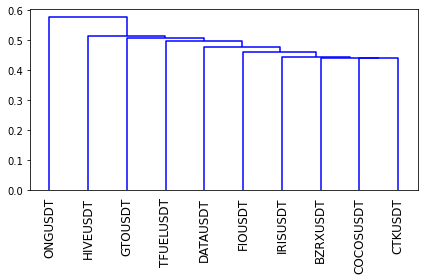

In [ ]:
# Hierarchical risk parity
hrp = HRPOpt(df.pct_change())
weights = hrp.optimize()
hrp.portfolio_performance(verbose=True)
print(weights)
plotting.plot_dendrogram(hrp)  # to plot dendrogram

# geting the allocation per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 26)

allocation, leftover = da.lp_portfolio()
print('discret allocation: ', allocation)
print('funds remaining: ${:.2f}'.format(leftover))

OrderedDict([('TFUELUSDT', 1.0), ('COCOSUSDT', 0.0), ('HIVEUSDT', 0.0), ('DATAUSDT', 0.0), ('ONGUSDT', 0.0), ('IRISUSDT', 0.0), ('BZRXUSDT', 0.0), ('FIOUSDT', 0.0), ('GTOUSDT', 6.938893901172926e-18), ('CTKUSDT', 0.0)])
Expected annual return: 3934.4%
Annual volatility: 169.6%
Sharpe Ratio: 23.19
discret allocation:  {'TFUELUSDT': 50}
funds remaining: $0.04


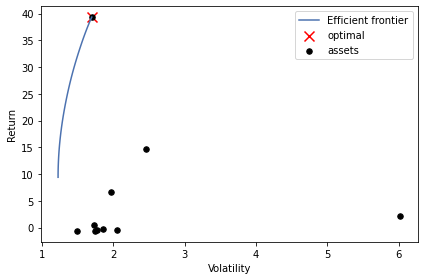

In [ ]:
# Crticial Line Algorithm
cla = CLA(mu, S)
weights = cla.max_sharpe()
print(cla.max_sharpe())
cla.portfolio_performance(verbose=True)
plotting.plot_efficient_frontier(cla)  # to plot

# geting the allocation per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 26)

allocation, leftover = da.lp_portfolio()
print('discret allocation: ', allocation)
print('funds remaining: ${:.2f}'.format(leftover))